In [1]:
import sys
import shutil
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/langevin/langevin/dev/flopy3fork.git/flopy


In [2]:
# Path to the MODFLOW 6 repository
mf6path = '../../../modflow6-fork.git'
assert os.path.isdir(mf6path)

In [3]:
mf6exe = os.path.join(mf6path, 'bin', 'mf6')
mf6exe = os.path.abspath(mf6exe)
assert os.path.isfile(mf6exe)
print(mf6exe)

/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6


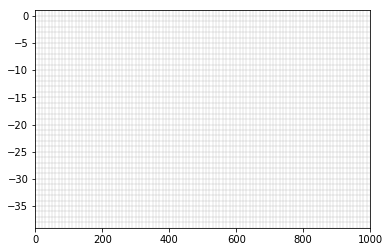

In [4]:
def make_grid(nlay, nrow, ncol, lx, top0, bottom):
    top = np.zeros((nrow, ncol), dtype=np.float)
    botm = np.zeros((nlay, nrow, ncol), dtype=np.float)

    delr = lx / ncol
    delc = 1.
    delv = (top0 - bottom) / nlay
    top[:, :] = top0
    
    for k in range(nlay):
        tp = top0
        if k > 0:
            tp = botm[k - 1, 0, 0]
        botm[k, :, :] = tp - delv
    
    delr = np.ones((ncol)) * delr
    delc = np.ones((nrow)) * delc
    return (delr, delc, top, botm)

nlay = 40
nrow = 1
ncol = 100
lx = 1000.
top0 = 1.
bottom = -39.
delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0, bottom)
mg = flopy.discretization.StructuredGrid(nlay=nlay, nrow=nrow, ncol=ncol,
                                         delr=delr, delc=delc, top=top, botm=botm)
pxs = flopy.plot.PlotCrossSection(modelgrid=mg, line={'row': 0})
pxs.plot_grid(alpha=1., lw=0.1)


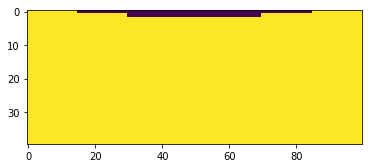

In [5]:
def lakeidomain(nrow, ncol, lx, top0, bottom, lakebot):
    import flopy.discretization as fgrid
    from shapely.geometry import Polygon
    from flopy.utils.gridintersect import GridIntersect
    ilak = np.ones((nrow, ncol), dtype=np.int)
    delr = lx / ncol * np.ones(ncol)
    delc = (top0 - bottom) / nrow * np.ones(nrow)
    xoff = 0.
    yoff = bottom
    sgr = fgrid.StructuredGrid(delc, delr, top=None, botm=None, xoff=xoff, yoff=yoff)
    poly = [(150, top0), (850, top0), (550, lakebot), (450, lakebot), (150, top0)]
    p = Polygon(shell=poly)
    ix = GridIntersect(sgr)
    result = ix.intersect_polygon(p)
    for i, j in result['cellids']:
        ilak[i, j] = 0
    return ilak
    
#lakeidomain = lakeidomain(nlay, ncol, 1000, top0, bottom, -1)
idomain = lakeidomain(nlay, ncol, lx, top0, bottom, -1)
plt.imshow(idomain)
#pmv = flopy.plot.PlotMapView(modelgrid=sgr)
#pmv.plot_grid()

In [6]:
def calcdens(c, rho0=1000., drhodc=0.7):
    return rho0 + drhodc * c

def get_sealevel(t, sl_start, slr_rate):
    return sl_start + slr_rate * t

def get_top(x, top0, slopels):
    return top0 + x * slopels

In [7]:
def get_model(ws, name, nlay, nrow, ncol, lx, top0, bottom,
              time_end,
              hk, vk, specific_storage, porosity, 
              rechgarge,
              alpha_l, alpha_t,
              cfresh, csalt,
              hlak=0., clak=0.,
              sl_start=0., slr_rate=0.,
              nper=100,
              hstrt=None, cstrt=None,
              lakeon=True,
              converge_continue=False,
              verbosity_level=1):

    delr, delc, top, botm = make_grid(nlay, nrow, ncol, lx, top0, bottom)

    nstp = 1
    perlen = nper * [time_end / nper]
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp, 1.0))

    nouter, ninner = 100, 300
    hclose, rclose, relax = 1e-7, 1e-5, 0.97

    # build MODFLOW 6 files
    sim = flopy.mf6.MFSimulation(sim_name=name, version='mf6',
                                 exe_name=mf6exe,
                                 verbosity_level=verbosity_level,
                                 sim_ws=ws)
    if converge_continue:
        sim.name_file.continue_ = True
    # create tdis package
    tdis = flopy.mf6.ModflowTdis(sim, time_units='DAYS',
                                 nper=nper, perioddata=tdis_rc)

    # create gwf model
    gwfname = 'gwf_' + name
    gwtname = 'gwt_' + name
    
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, newtonoptions=True)
    imsgwf = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                  outer_hclose=hclose,
                                  outer_maximum=nouter,
                                  under_relaxation='DBD',
                                  inner_maximum=ninner,
                                  inner_hclose=hclose, rcloserecord=rclose,
                                  linear_acceleration='BICGSTAB',
                                  scaling_method='NONE',
                                  reordering_method='NONE',
                                  relaxation_factor=relax,
                                  no_ptcrecord=True,
                                  filename='{}.ims'.format(gwfname))
    single_matrix = False
    if single_matrix:
        sim.register_ims_package(imsgwf, [gwfname, gwtname])
    else:
        sim.register_ims_package(imsgwf, [gwfname])

    idomain = None
    if lakeon:
        lakebot = -1
        idomain = lakeidomain(nlay, ncol, lx, top0, bottom, lakebot)
        idomain = idomain.reshape((nlay, nrow, ncol))
    dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm, idomain=idomain)

    # initial conditions
    if hstrt is None:
        hstrt = top0
    else:
        hstrt = {'filename': 'hstrt.bin', 'factor': 1.0, 
                 'data': hstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwfic(gwf, strt=hstrt)

    # node property flow
    npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=False,
                                  save_flows=True,
                                  save_specific_discharge=True,
                                  icelltype=1,
                                  k=hk, k33=vk)
    
    sto = flopy.mf6.ModflowGwfsto(gwf, iconvert=1, sy=porosity, ss=specific_storage)

    hhformulation = True
    hhoptions = False
    if hhformulation:
        hhoptions = [('HHFORMULATION'), ]
        hhoptions.append(('LHS'))
    buy = flopy.mf6.ModflowGwfbuy(gwf, hhoptions=hhoptions)
    

    xc, yc, zc = gwf.modelgrid.xyzcellcenters
    botm = gwf.modelgrid.botm
    delt = time_end / nper
    delv = (top0 - bottom) / nlay
    ghbdict = {}
    for iper, t in enumerate(np.arange(delt, time_end + delt, delt)):
        sl = get_sealevel(t, sl_start, slr_rate)
        ghblist = []
        cond = hk * delc[0] * delv / (0.5 * delr[0])
        for k in range(nlay):
            ghbl = [(k, 0, 0), sl, cond, csalt, calcdens(csalt), zc[k, 0, 0]]
            ghbr = [(k, 0, ncol - 1), sl, cond, csalt, calcdens(csalt), zc[k, 0, ncol - 1]]
            if sl > botm[k, 0, 0]:
                ghblist.append(ghbl)
                ghblist.append(ghbr)
        ghbdict[iper] = ghblist
    
    #ghblak = [(0, 0, int(ncol / 2)), 0., cond*100, cfresh, calcdens(cfresh), zc[0, 0, 0]]
    #ghblist.append(ghblak)

    if len(ghbdict) > 0:
        ghb = flopy.mf6.ModflowGwfghb(gwf,
                                      stress_period_data=ghbdict,
                                      print_input=True,
                                      print_flows=True,
                                      save_flows=False,
                                      auxiliary=['CONCENTRATION', 'DENSITY', 'ELEVATION'],
                                      pname='GHB-0')
    
    rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge)
    
    if lakeon:
        ilakeabove = np.zeros((nlay, nrow, ncol), dtype=np.int)
        for k in range(nlay):
            for j in range(ncol):
                if idomain[k, 0, j] == 0:
                    ilakeabove[k + 1, 0, j] = 1
                    ilakeabove[k, 0, j] = 0
        klak, ilak, jlak = np.where(ilakeabove == 1)
        nlakconn = klak.shape[0]
        pak_data = [(0, hlak, nlakconn, 0.)]
        bedleak = 0.1 * vk / (0.5 * delv)
        con_data = []
        for iconn, (k, i, j) in enumerate(zip(klak, ilak, jlak)):
            con_data.append([0, iconn, (k, i, j), 'VERTICAL', bedleak, 10., 10., 1, 1])
        p_data = [(0, 'EVAPORATION', 0.5 * recharge), (0, 'RAINFALL', recharge)]
        lak = flopy.mf6.ModflowGwflak(gwf, nlakes=1, stage_filerecord='stage',
                                      print_stage=True, print_flows=True,
                                      packagedata=pak_data,
                                      connectiondata=con_data,
                                      lakeperioddata=p_data,
                                      pname='LAK0',
                                      auxiliary='CONCENTRATION')
    
    # output control
    saverecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'ALL')]}
    printrecord = {0: [('HEAD', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('HEAD', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(gwfname),
                                head_filerecord='{}.hds'.format(gwfname),
                                headprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # create gwt model
    gwt = flopy.mf6.MFModel(sim, model_type='gwt6', modelname=gwtname,
                            model_nam_file='{}.nam'.format(gwtname))

    if not single_matrix:
        imsgwt = flopy.mf6.ModflowIms(sim, print_option='ALL',
                                      outer_hclose=hclose,
                                      outer_maximum=nouter,
                                      under_relaxation='NONE',
                                      inner_maximum=ninner,
                                      inner_hclose=hclose, rcloserecord=rclose,
                                      linear_acceleration='BICGSTAB',
                                      scaling_method='NONE',
                                      reordering_method='NONE',
                                      relaxation_factor=relax,
                                      filename='{}.ims'.format(gwtname))
        sim.register_ims_package(imsgwt, [gwt.name])

    dis = flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
                                  delr=delr, delc=delc,
                                  top=top, botm=botm, idomain=idomain)

    # initial conditions
    if cstrt is None:
        cstrt = csalt
    else:
        cstrt = {'filename': 'cstrt.bin', 'factor': 1.0, 
                 'data': cstrt, 'binary': 'True'}
    ic = flopy.mf6.ModflowGwtic(gwt, strt=cstrt)

    # advection
    adv = flopy.mf6.ModflowGwtadv(gwt, scheme='UPSTREAM')

    # dispersion
    #dsp = flopy.mf6.ModflowGwtdsp(gwt, xt3d=False, diffc=0.,
    #                              alh=alpha_l, ath1=alpha_t)

    # mass storage and transfer
    porosity = porosity
    mst = flopy.mf6.ModflowGwtmst(gwt, porosity=porosity)
    
    # sources
    sourcerecarray = [('GHB-0', 'AUX', 'CONCENTRATION')]
    ssm = flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray,
                                  filename='{}.ssm'.format(gwtname))
    
    if lakeon:
        packagedata = [(0, clak)]
        lakeperioddata = [(0, 'RAINFALL', 0.)]
        lkt = flopy.mf6.ModflowGwtlkt(gwt, print_concentration=True,
                                      concentration_filerecord='lakconc.bin',
                                      packagedata=packagedata, 
                                      lakeperioddata=lakeperioddata,
                                      pname='LAK0')

    # output control
    saverecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: [('CONCENTRATION', 'ALL')],
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    printrecord = {0: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')],
                  1: None,
                  nper - 1: [('CONCENTRATION', 'ALL'), ('BUDGET', 'LAST')]}
    oc = flopy.mf6.ModflowGwtoc(gwt,
                                budget_filerecord='{}.cbc'.format(gwtname),
                                concentration_filerecord='{}.ucn'.format(
                                    gwtname),
                                concentrationprintrecord=[
                                    ('COLUMNS', 10, 'WIDTH', 15,
                                     'DIGITS', 6, 'GENERAL')],
                                saverecord=saverecord,
                                printrecord=printrecord)

    # GWF GWT exchange
    gwfgwt = flopy.mf6.ModflowGwfgwt(sim, exgtype='GWF6-GWT6',
                                     exgmnamea=gwfname, exgmnameb=gwtname,
                                     filename='{}.gwfgwt'.format(name))

    return sim

In [16]:
def get_results(ws, sim):
    modelnames = list(sim.model_names)
    gwfname = modelnames[0]
    gwtname = modelnames[1]
    gwf = sim.get_model(gwfname)
    gwt = sim.get_model(gwtname)

    fname = os.path.join(ws, gwfname + '.hds')
    hdobj = flopy.utils.HeadFile(fname, precision='double')
    head = hdobj.get_alldata()

    fname = os.path.join(ws, gwtname + '.ucn')
    cnobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
    conc = cnobj.get_alldata()
    times = cnobj.get_times()
    
    fname = os.path.join(ws, gwfname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = budobj.get_data(text='DATA-SPDIS')
    
    fname = os.path.join(ws, 'stage')
    lakstage = None
    if os.path.exists(fname):
        stobj = flopy.utils.HeadFile(fname, precision='double', text='STAGE')
        lakstage = stobj.get_alldata()

    fname = os.path.join(ws, 'lakconc.bin')
    lakconc = None
    if os.path.exists(fname):
        lkcobj = flopy.utils.HeadFile(fname, precision='double', text='CONCENTRATION')
        lakconc = lkcobj.get_alldata()

    
    return head, conc, spdis, lakstage, lakconc, times

In [9]:
def get_colored_patch_collection(modelgrid, head=None, ec='k', fc='k', zorder=None):
    # create patches for each cell
    xv, yv, zv = modelgrid.xyzvertices
    patches = []
    for k in range(modelgrid.nlay):
        for j in range(modelgrid.ncol):
            x0 = xv[0, j]
            x1 = xv[0, j + 1]
            y0 = zv[k, 0, j]
            y1 = zv[k + 1, 0, j]
            if head is not None:
                y0 = min(y0, head[k, 0, j])
                y0 = max(y0, modelgrid.botm[k, 0, j])
            poly = [[x0, y0], [x1, y0], [x1, y1], [x0, y1], [x0, y0]]
            #print(poly)
            patch = matplotlib.patches.Polygon(poly, closed=True, edgecolor=ec, facecolor=fc)
            patches.append(patch)
    pc = matplotlib.collections.PatchCollection(patches, zorder=zorder, match_original=True, cmap='jet')
    return pc

In [10]:
def make_figure(gwf, head, conc, spdis, t, top0, csalt=35., 
                ax2dict=None, asoln=None, streamplot=False, vectors=False,
                figname=None):

    plt.rcParams['savefig.facecolor'] = '1.0'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 5)
    #ax.set_aspect('equal')
    
    pxs = flopy.plot.PlotCrossSection(model=gwf, line={'row': 0}, ax=ax)
    pxs.plot_grid(alpha=1., lw=0.1)

    # draw a patch collection, with the water table as the top of the cell
    pc = get_colored_patch_collection(gwf.modelgrid, head, ec='none', fc='none', zorder=2)
    pc.set_array(conc.flatten())
    ax.add_collection(pc)

    cbar = plt.colorbar(pc, shrink=0.5)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('CONCENTRATION, IN GRAMS PER LITER', rotation=90)
    
    # 50% seawater line
    atoplot = np.ma.masked_where(head < gwf.dis.botm.array, conc)
    pxs.contour_array(atoplot, levels=np.array([.5])* csalt, 
                      linestyles = ['-'], colors=['k'])

    if vectors:
        pxs.plot_specific_discharge(spdis, head=head, color='white',
                                    kstep=1, hstep=1, pivot='mid', minlength=0.5,
                                    scale=0.1, width=0.001, headwidth=3., headlength=5.0, 
                                    headaxislength=4.5, minshaft=0.01,
                                    zorder=10, alpha=0.50)
    
    if streamplot:
        x = gwf.modelgrid.xcellcenters
        y = gwf.modelgrid.zcellcenters
        X, Y = np.meshgrid(x, y[:, 0, 0])
        u = spdis['qx']
        u = u.reshape(X.shape)
        v = spdis['qz']
        v = v.reshape(X.shape)
        sc = ax.streamplot(X, Y, u, v, color='yellow', linewidth=0.1, arrowsize=0.35)

    # head surface
    #ax.plot(gwf.modelgrid.xcellcenters[0], head[kper, 0, 0, :])
    #plt.colorbar(qm, shrink=0.5)
    ax.set_title('TIME = {:.2f} years'.format(t / 365.))
    ax.set_xlabel('DISTANCE, IN METERS')
    ax.set_ylabel('ELEVATION, IN METERS')
    
    plt.tight_layout()
    
    if ax2dict is not None:
        with plt.rc_context({'axes.edgecolor':'white', 
                             'axes.facecolor':'yellow',
                             'xtick.color':'white', 
                             'ytick.color':'white', 
                             'font.size': 8,
                             'axes.labelcolor': 'white',
                             }):
            if 'limits' in ax2dict:
                limits = ax2dict['limits']
            else:
                limits = [0.15, 0.22, 0.2, 0.2]
            xdata = ax2dict['xdata']
            ydata = ax2dict['ydata']
            ax2 = fig.add_axes(limits)
            ax2.plot(xdata, ydata, 'k-')
            if 'xlim' in ax2dict:
                ax2.set_xlim(*ax2dict['xlim'])
            if 'ylim' in ax2dict:
                ax2.set_ylim(*ax2dict['ylim'])
            if 'xlabel' in ax2dict:
                ax2.set_xlabel(ax2dict['xlabel'])
            if 'ylabel' in ax2dict:
                ax2.set_ylabel(ax2dict['ylabel'])
    
    if figname is not None:
        plt.savefig(figname, dpi=300)
        plt.close(fig)
        
    return ax

In [11]:
def make_movie(figfile, anmfile):
    from subprocess import check_output
    vcodec = 'libx264'
    if os.path.isfile(anmfile):
        os.remove(anmfile)
    output = check_output(['ffmpeg',
                           '-f', 'image2',
                           '-i', figfile,
                           '-vb', '20M',
                           '-vcodec', vcodec,
                           '-pix_fmt', 'yuv420p',
                           anmfile])    

In [12]:
# Protection
sim = None
sim0 = None
gwf = None
ws = None
ws0 = None
head = None
head0 = None
conc = None
conc0 = None

# Model Run (No SLR)

In [13]:
nlay = 20
nrow = 1
ncol = 40
lx = 1000.
top0 = 2.
bottom = -50.
nper = 3000
time_end = 365 * 1000.
cfresh = 0.
csalt = 35.
recharge = 0.0005 
porosity = 0.35
hk = 10. # m/day
vk = 10.
specific_storage = 0.008 # per meter
alpha_l = 0. # meter
alpha_t = 0.0 # meter
cstrt = csalt

In [14]:
ws0 = 'temp/pxx_gwt_lakoffslr'
name = 'lakslr'
sim0 = get_model(ws0, name, nlay, nrow, ncol, lx,
                 top0, bottom, 
                 time_end, 
                 hk, vk, specific_storage, porosity, 
                 recharge,
                 alpha_l, alpha_t,
                 cfresh, csalt, nper=nper, cstrt=cstrt,
                 verbosity_level=1,
                 lakeon=False,
                 converge_continue=True)
sim0.write_simulation()
v = sim0.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package lakslr.gwfgwt...
  writing model gwf_lakslr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 40 based on size of stress_period_data
    writing package rcha...
    writing package oc...
  writing model gwt_lakslr...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR

 Solving:  Stress period:   145    Time step:     1
 Solving:  Stress period:   146    Time step:     1
 Solving:  Stress period:   147    Time step:     1
 Solving:  Stress period:   148    Time step:     1
 Solving:  Stress period:   149    Time step:     1
 Solving:  Stress period:   150    Time step:     1
 Solving:  Stress period:   151    Time step:     1
 Solving:  Stress period:   152    Time step:     1
 Solving:  Stress period:   153    Time step:     1
 Solving:  Stress period:   154    Time step:     1
 Solving:  Stress period:   155    Time step:     1
 Solving:  Stress period:   156    Time step:     1
 Solving:  Stress period:   157    Time step:     1
 Solving:  Stress period:   158    Time step:     1
 Solving:  Stress period:   159    Time step:     1
 Solving:  Stress period:   160    Time step:     1
 Solving:  Stress period:   161    Time step:     1
 Solving:  Stress period:   162    Time step:     1
 Solving:  Stress period:   163    Time step:     1
 Solving:  S

 Solving:  Stress period:   331    Time step:     1
 Solving:  Stress period:   332    Time step:     1
 Solving:  Stress period:   333    Time step:     1
 Solving:  Stress period:   334    Time step:     1
 Solving:  Stress period:   335    Time step:     1
 Solving:  Stress period:   336    Time step:     1
 Solving:  Stress period:   337    Time step:     1
 Solving:  Stress period:   338    Time step:     1
 Solving:  Stress period:   339    Time step:     1
 Solving:  Stress period:   340    Time step:     1
 Solving:  Stress period:   341    Time step:     1
 Solving:  Stress period:   342    Time step:     1
 Solving:  Stress period:   343    Time step:     1
 Solving:  Stress period:   344    Time step:     1
 Solving:  Stress period:   345    Time step:     1
 Solving:  Stress period:   346    Time step:     1
 Solving:  Stress period:   347    Time step:     1
 Solving:  Stress period:   348    Time step:     1
 Solving:  Stress period:   349    Time step:     1
 Solving:  S

 Solving:  Stress period:   527    Time step:     1
 Solving:  Stress period:   528    Time step:     1
 Solving:  Stress period:   529    Time step:     1
 Solving:  Stress period:   530    Time step:     1
 Solving:  Stress period:   531    Time step:     1
 Solving:  Stress period:   532    Time step:     1
 Solving:  Stress period:   533    Time step:     1
 Solving:  Stress period:   534    Time step:     1
 Solving:  Stress period:   535    Time step:     1
 Solving:  Stress period:   536    Time step:     1
 Solving:  Stress period:   537    Time step:     1
 Solving:  Stress period:   538    Time step:     1
 Solving:  Stress period:   539    Time step:     1
 Solving:  Stress period:   540    Time step:     1
 Solving:  Stress period:   541    Time step:     1
 Solving:  Stress period:   542    Time step:     1
 Solving:  Stress period:   543    Time step:     1
 Solving:  Stress period:   544    Time step:     1
 Solving:  Stress period:   545    Time step:     1
 Solving:  S

 Solving:  Stress period:   734    Time step:     1
 Solving:  Stress period:   735    Time step:     1
 Solving:  Stress period:   736    Time step:     1
 Solving:  Stress period:   737    Time step:     1
 Solving:  Stress period:   738    Time step:     1
 Solving:  Stress period:   739    Time step:     1
 Solving:  Stress period:   740    Time step:     1
 Solving:  Stress period:   741    Time step:     1
 Solving:  Stress period:   742    Time step:     1
 Solving:  Stress period:   743    Time step:     1
 Solving:  Stress period:   744    Time step:     1
 Solving:  Stress period:   745    Time step:     1
 Solving:  Stress period:   746    Time step:     1
 Solving:  Stress period:   747    Time step:     1
 Solving:  Stress period:   748    Time step:     1
 Solving:  Stress period:   749    Time step:     1
 Solving:  Stress period:   750    Time step:     1
 Solving:  Stress period:   751    Time step:     1
 Solving:  Stress period:   752    Time step:     1
 Solving:  S

 Solving:  Stress period:   897    Time step:     1
 Solving:  Stress period:   898    Time step:     1
 Solving:  Stress period:   899    Time step:     1
 Solving:  Stress period:   900    Time step:     1
 Solving:  Stress period:   901    Time step:     1
 Solving:  Stress period:   902    Time step:     1
 Solving:  Stress period:   903    Time step:     1
 Solving:  Stress period:   904    Time step:     1
 Solving:  Stress period:   905    Time step:     1
 Solving:  Stress period:   906    Time step:     1
 Solving:  Stress period:   907    Time step:     1
 Solving:  Stress period:   908    Time step:     1
 Solving:  Stress period:   909    Time step:     1
 Solving:  Stress period:   910    Time step:     1
 Solving:  Stress period:   911    Time step:     1
 Solving:  Stress period:   912    Time step:     1
 Solving:  Stress period:   913    Time step:     1
 Solving:  Stress period:   914    Time step:     1
 Solving:  Stress period:   915    Time step:     1
 Solving:  S

 Solving:  Stress period:  1055    Time step:     1
 Solving:  Stress period:  1056    Time step:     1
 Solving:  Stress period:  1057    Time step:     1
 Solving:  Stress period:  1058    Time step:     1
 Solving:  Stress period:  1059    Time step:     1
 Solving:  Stress period:  1060    Time step:     1
 Solving:  Stress period:  1061    Time step:     1
 Solving:  Stress period:  1062    Time step:     1
 Solving:  Stress period:  1063    Time step:     1
 Solving:  Stress period:  1064    Time step:     1
 Solving:  Stress period:  1065    Time step:     1
 Solving:  Stress period:  1066    Time step:     1
 Solving:  Stress period:  1067    Time step:     1
 Solving:  Stress period:  1068    Time step:     1
 Solving:  Stress period:  1069    Time step:     1
 Solving:  Stress period:  1070    Time step:     1
 Solving:  Stress period:  1071    Time step:     1
 Solving:  Stress period:  1072    Time step:     1
 Solving:  Stress period:  1073    Time step:     1
 Solving:  S

 Solving:  Stress period:  1214    Time step:     1
 Solving:  Stress period:  1215    Time step:     1
 Solving:  Stress period:  1216    Time step:     1
 Solving:  Stress period:  1217    Time step:     1
 Solving:  Stress period:  1218    Time step:     1
 Solving:  Stress period:  1219    Time step:     1
 Solving:  Stress period:  1220    Time step:     1
 Solving:  Stress period:  1221    Time step:     1
 Solving:  Stress period:  1222    Time step:     1
 Solving:  Stress period:  1223    Time step:     1
 Solving:  Stress period:  1224    Time step:     1
 Solving:  Stress period:  1225    Time step:     1
 Solving:  Stress period:  1226    Time step:     1
 Solving:  Stress period:  1227    Time step:     1
 Solving:  Stress period:  1228    Time step:     1
 Solving:  Stress period:  1229    Time step:     1
 Solving:  Stress period:  1230    Time step:     1
 Solving:  Stress period:  1231    Time step:     1
 Solving:  Stress period:  1232    Time step:     1
 Solving:  S

 Solving:  Stress period:  1421    Time step:     1
 Solving:  Stress period:  1422    Time step:     1
 Solving:  Stress period:  1423    Time step:     1
 Solving:  Stress period:  1424    Time step:     1
 Solving:  Stress period:  1425    Time step:     1
 Solving:  Stress period:  1426    Time step:     1
 Solving:  Stress period:  1427    Time step:     1
 Solving:  Stress period:  1428    Time step:     1
 Solving:  Stress period:  1429    Time step:     1
 Solving:  Stress period:  1430    Time step:     1
 Solving:  Stress period:  1431    Time step:     1
 Solving:  Stress period:  1432    Time step:     1
 Solving:  Stress period:  1433    Time step:     1
 Solving:  Stress period:  1434    Time step:     1
 Solving:  Stress period:  1435    Time step:     1
 Solving:  Stress period:  1436    Time step:     1
 Solving:  Stress period:  1437    Time step:     1
 Solving:  Stress period:  1438    Time step:     1
 Solving:  Stress period:  1439    Time step:     1
 Solving:  S

 Solving:  Stress period:  1627    Time step:     1
 Solving:  Stress period:  1628    Time step:     1
 Solving:  Stress period:  1629    Time step:     1
 Solving:  Stress period:  1630    Time step:     1
 Solving:  Stress period:  1631    Time step:     1
 Solving:  Stress period:  1632    Time step:     1
 Solving:  Stress period:  1633    Time step:     1
 Solving:  Stress period:  1634    Time step:     1
 Solving:  Stress period:  1635    Time step:     1
 Solving:  Stress period:  1636    Time step:     1
 Solving:  Stress period:  1637    Time step:     1
 Solving:  Stress period:  1638    Time step:     1
 Solving:  Stress period:  1639    Time step:     1
 Solving:  Stress period:  1640    Time step:     1
 Solving:  Stress period:  1641    Time step:     1
 Solving:  Stress period:  1642    Time step:     1
 Solving:  Stress period:  1643    Time step:     1
 Solving:  Stress period:  1644    Time step:     1
 Solving:  Stress period:  1645    Time step:     1
 Solving:  S

 Solving:  Stress period:  1789    Time step:     1
 Solving:  Stress period:  1790    Time step:     1
 Solving:  Stress period:  1791    Time step:     1
 Solving:  Stress period:  1792    Time step:     1
 Solving:  Stress period:  1793    Time step:     1
 Solving:  Stress period:  1794    Time step:     1
 Solving:  Stress period:  1795    Time step:     1
 Solving:  Stress period:  1796    Time step:     1
 Solving:  Stress period:  1797    Time step:     1
 Solving:  Stress period:  1798    Time step:     1
 Solving:  Stress period:  1799    Time step:     1
 Solving:  Stress period:  1800    Time step:     1
 Solving:  Stress period:  1801    Time step:     1
 Solving:  Stress period:  1802    Time step:     1
 Solving:  Stress period:  1803    Time step:     1
 Solving:  Stress period:  1804    Time step:     1
 Solving:  Stress period:  1805    Time step:     1
 Solving:  Stress period:  1806    Time step:     1
 Solving:  Stress period:  1807    Time step:     1
 Solving:  S

 Solving:  Stress period:  1951    Time step:     1
 Solving:  Stress period:  1952    Time step:     1
 Solving:  Stress period:  1953    Time step:     1
 Solving:  Stress period:  1954    Time step:     1
 Solving:  Stress period:  1955    Time step:     1
 Solving:  Stress period:  1956    Time step:     1
 Solving:  Stress period:  1957    Time step:     1
 Solving:  Stress period:  1958    Time step:     1
 Solving:  Stress period:  1959    Time step:     1
 Solving:  Stress period:  1960    Time step:     1
 Solving:  Stress period:  1961    Time step:     1
 Solving:  Stress period:  1962    Time step:     1
 Solving:  Stress period:  1963    Time step:     1
 Solving:  Stress period:  1964    Time step:     1
 Solving:  Stress period:  1965    Time step:     1
 Solving:  Stress period:  1966    Time step:     1
 Solving:  Stress period:  1967    Time step:     1
 Solving:  Stress period:  1968    Time step:     1
 Solving:  Stress period:  1969    Time step:     1
 Solving:  S

 Solving:  Stress period:  2115    Time step:     1
 Solving:  Stress period:  2116    Time step:     1
 Solving:  Stress period:  2117    Time step:     1
 Solving:  Stress period:  2118    Time step:     1
 Solving:  Stress period:  2119    Time step:     1
 Solving:  Stress period:  2120    Time step:     1
 Solving:  Stress period:  2121    Time step:     1
 Solving:  Stress period:  2122    Time step:     1
 Solving:  Stress period:  2123    Time step:     1
 Solving:  Stress period:  2124    Time step:     1
 Solving:  Stress period:  2125    Time step:     1
 Solving:  Stress period:  2126    Time step:     1
 Solving:  Stress period:  2127    Time step:     1
 Solving:  Stress period:  2128    Time step:     1
 Solving:  Stress period:  2129    Time step:     1
 Solving:  Stress period:  2130    Time step:     1
 Solving:  Stress period:  2131    Time step:     1
 Solving:  Stress period:  2132    Time step:     1
 Solving:  Stress period:  2133    Time step:     1
 Solving:  S

 Solving:  Stress period:  2277    Time step:     1
 Solving:  Stress period:  2278    Time step:     1
 Solving:  Stress period:  2279    Time step:     1
 Solving:  Stress period:  2280    Time step:     1
 Solving:  Stress period:  2281    Time step:     1
 Solving:  Stress period:  2282    Time step:     1
 Solving:  Stress period:  2283    Time step:     1
 Solving:  Stress period:  2284    Time step:     1
 Solving:  Stress period:  2285    Time step:     1
 Solving:  Stress period:  2286    Time step:     1
 Solving:  Stress period:  2287    Time step:     1
 Solving:  Stress period:  2288    Time step:     1
 Solving:  Stress period:  2289    Time step:     1
 Solving:  Stress period:  2290    Time step:     1
 Solving:  Stress period:  2291    Time step:     1
 Solving:  Stress period:  2292    Time step:     1
 Solving:  Stress period:  2293    Time step:     1
 Solving:  Stress period:  2294    Time step:     1
 Solving:  Stress period:  2295    Time step:     1
 Solving:  S

 Solving:  Stress period:  2435    Time step:     1
 Solving:  Stress period:  2436    Time step:     1
 Solving:  Stress period:  2437    Time step:     1
 Solving:  Stress period:  2438    Time step:     1
 Solving:  Stress period:  2439    Time step:     1
 Solving:  Stress period:  2440    Time step:     1
 Solving:  Stress period:  2441    Time step:     1
 Solving:  Stress period:  2442    Time step:     1
 Solving:  Stress period:  2443    Time step:     1
 Solving:  Stress period:  2444    Time step:     1
 Solving:  Stress period:  2445    Time step:     1
 Solving:  Stress period:  2446    Time step:     1
 Solving:  Stress period:  2447    Time step:     1
 Solving:  Stress period:  2448    Time step:     1
 Solving:  Stress period:  2449    Time step:     1
 Solving:  Stress period:  2450    Time step:     1
 Solving:  Stress period:  2451    Time step:     1
 Solving:  Stress period:  2452    Time step:     1
 Solving:  Stress period:  2453    Time step:     1
 Solving:  S

 Solving:  Stress period:  2634    Time step:     1
 Solving:  Stress period:  2635    Time step:     1
 Solving:  Stress period:  2636    Time step:     1
 Solving:  Stress period:  2637    Time step:     1
 Solving:  Stress period:  2638    Time step:     1
 Solving:  Stress period:  2639    Time step:     1
 Solving:  Stress period:  2640    Time step:     1
 Solving:  Stress period:  2641    Time step:     1
 Solving:  Stress period:  2642    Time step:     1
 Solving:  Stress period:  2643    Time step:     1
 Solving:  Stress period:  2644    Time step:     1
 Solving:  Stress period:  2645    Time step:     1
 Solving:  Stress period:  2646    Time step:     1
 Solving:  Stress period:  2647    Time step:     1
 Solving:  Stress period:  2648    Time step:     1
 Solving:  Stress period:  2649    Time step:     1
 Solving:  Stress period:  2650    Time step:     1
 Solving:  Stress period:  2651    Time step:     1
 Solving:  Stress period:  2652    Time step:     1
 Solving:  S

 Solving:  Stress period:  2832    Time step:     1
 Solving:  Stress period:  2833    Time step:     1
 Solving:  Stress period:  2834    Time step:     1
 Solving:  Stress period:  2835    Time step:     1
 Solving:  Stress period:  2836    Time step:     1
 Solving:  Stress period:  2837    Time step:     1
 Solving:  Stress period:  2838    Time step:     1
 Solving:  Stress period:  2839    Time step:     1
 Solving:  Stress period:  2840    Time step:     1
 Solving:  Stress period:  2841    Time step:     1
 Solving:  Stress period:  2842    Time step:     1
 Solving:  Stress period:  2843    Time step:     1
 Solving:  Stress period:  2844    Time step:     1
 Solving:  Stress period:  2845    Time step:     1
 Solving:  Stress period:  2846    Time step:     1
 Solving:  Stress period:  2847    Time step:     1
 Solving:  Stress period:  2848    Time step:     1
 Solving:  Stress period:  2849    Time step:     1
 Solving:  Stress period:  2850    Time step:     1
 Solving:  S

In [17]:
# load results
head0, conc0, spdis0, stage0, lakconc0, times0 = get_results(ws0, sim0)
gwf = sim0.get_model('gwf_lakslr')

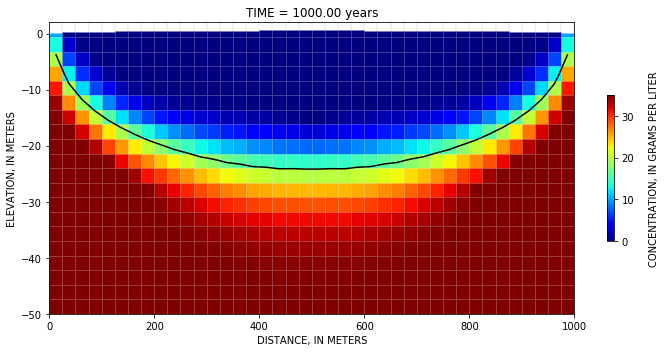

In [20]:
kper = -1
conctoplot = conc0[kper]
headtoplot = head0[kper]
if lakconc0 is not None:
    conctoplot = np.where(conctoplot > 1e20, lakconc0[kper, 0, 0, 0], conctoplot)
if stage0 is not None:
    headtoplot = np.where(headtoplot > 1e20, stage0[kper, 0, 0, 0], headtoplot)
ax = make_figure(gwf, headtoplot, conctoplot, spdis0[kper], 
                 times0[kper], top0, streamplot=False)

writing temp/pxx_gwt_lakoffslr/png/img0.png


/Users/langevin/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


writing temp/pxx_gwt_lakoffslr/png/img1.png
writing temp/pxx_gwt_lakoffslr/png/img2.png
writing temp/pxx_gwt_lakoffslr/png/img3.png
writing temp/pxx_gwt_lakoffslr/png/img4.png
writing temp/pxx_gwt_lakoffslr/png/img5.png
writing temp/pxx_gwt_lakoffslr/png/img6.png
writing temp/pxx_gwt_lakoffslr/png/img7.png
writing temp/pxx_gwt_lakoffslr/png/img8.png
writing temp/pxx_gwt_lakoffslr/png/img9.png
writing temp/pxx_gwt_lakoffslr/png/img10.png
writing temp/pxx_gwt_lakoffslr/png/img11.png
writing temp/pxx_gwt_lakoffslr/png/img12.png
writing temp/pxx_gwt_lakoffslr/png/img13.png
writing temp/pxx_gwt_lakoffslr/png/img14.png
writing temp/pxx_gwt_lakoffslr/png/img15.png
writing temp/pxx_gwt_lakoffslr/png/img16.png
writing temp/pxx_gwt_lakoffslr/png/img17.png
writing temp/pxx_gwt_lakoffslr/png/img18.png
writing temp/pxx_gwt_lakoffslr/png/img19.png
writing temp/pxx_gwt_lakoffslr/png/img20.png
writing temp/pxx_gwt_lakoffslr/png/img21.png
writing temp/pxx_gwt_lakoffslr/png/img22.png
writing temp/pxx_gw

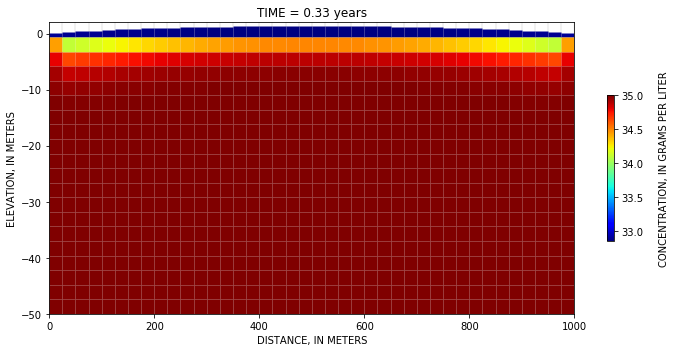

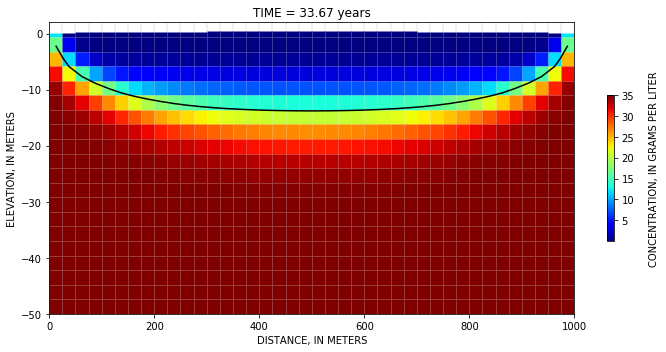

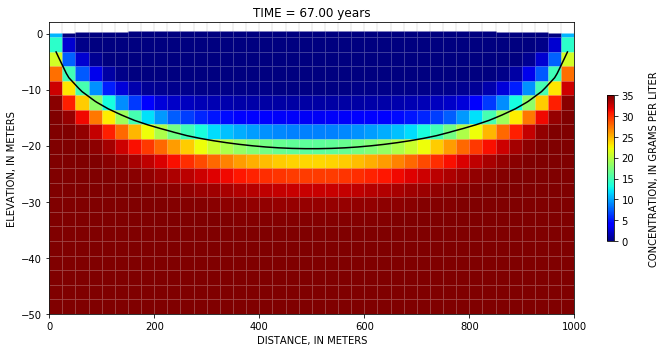

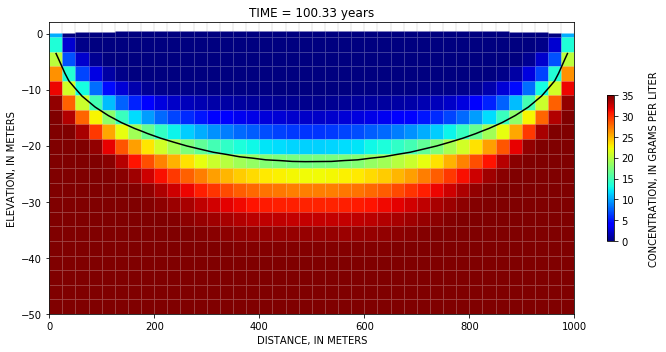

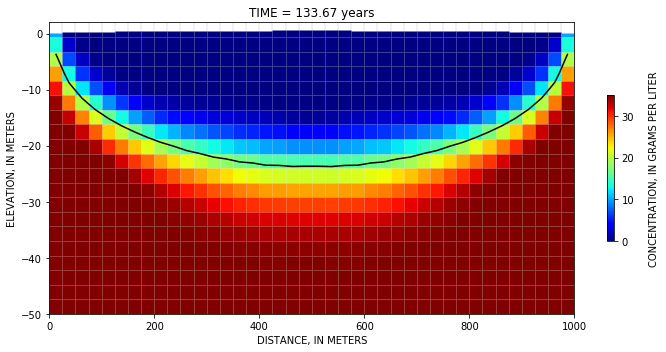

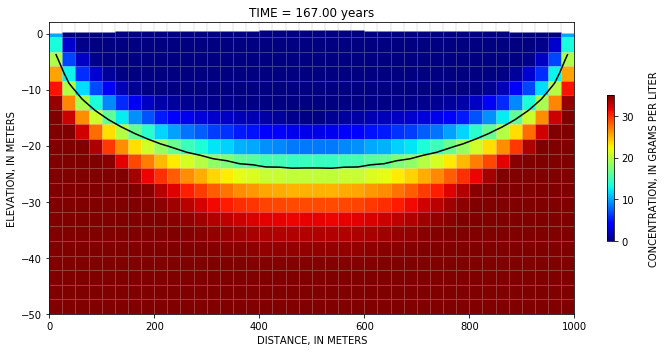

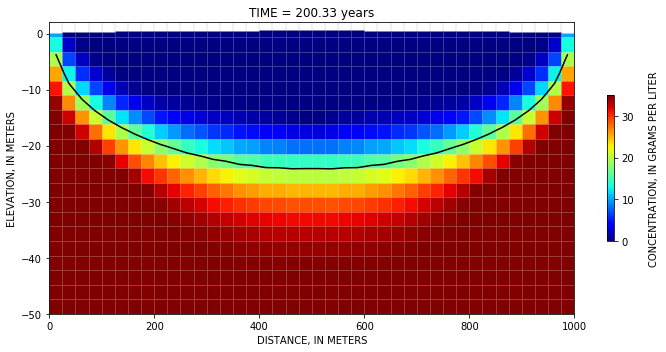

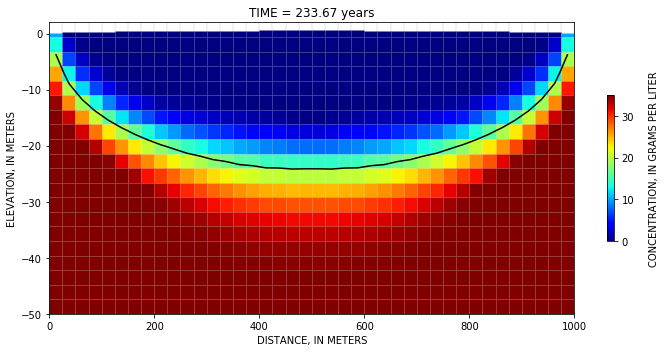

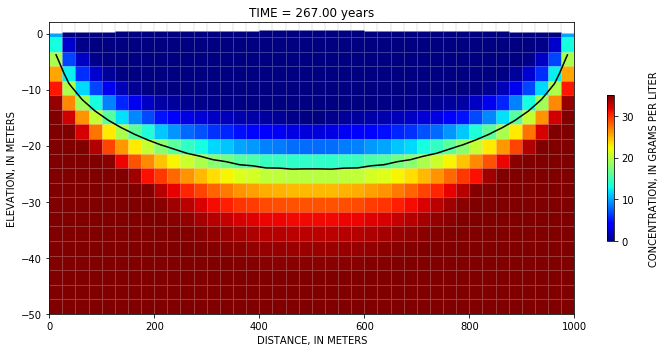

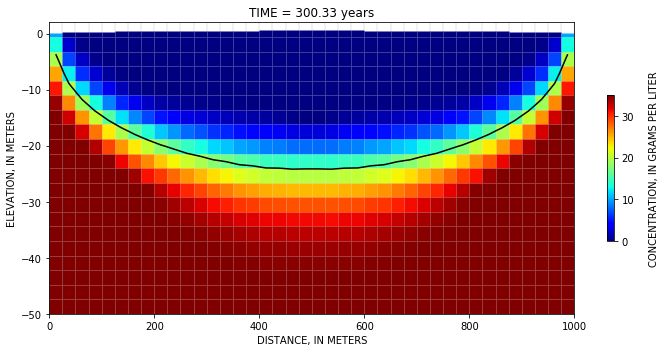

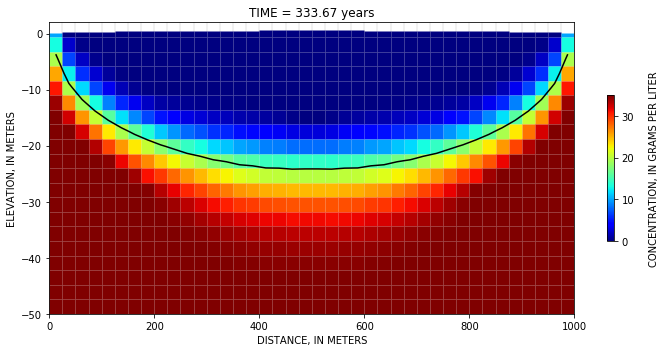

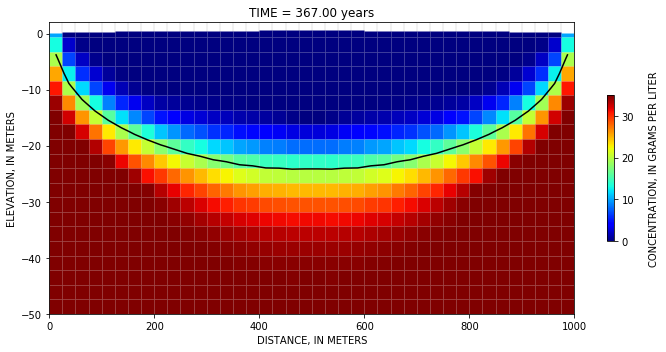

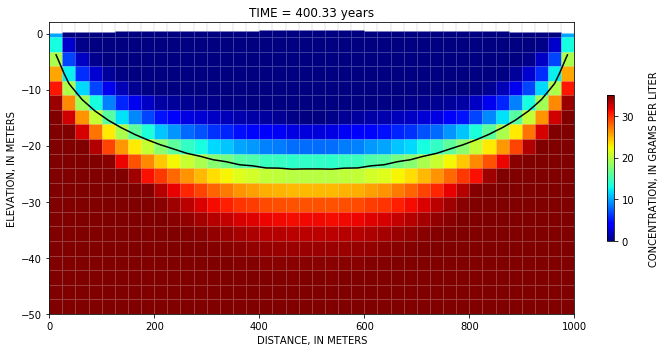

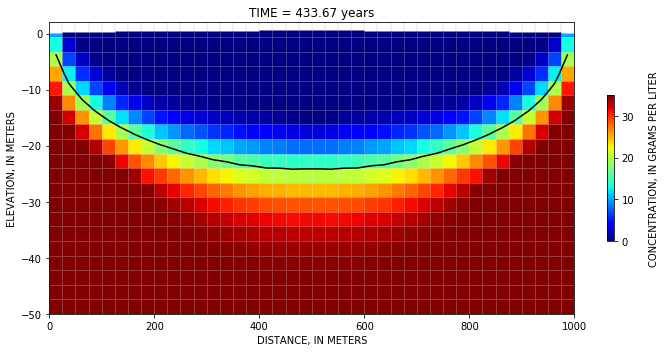

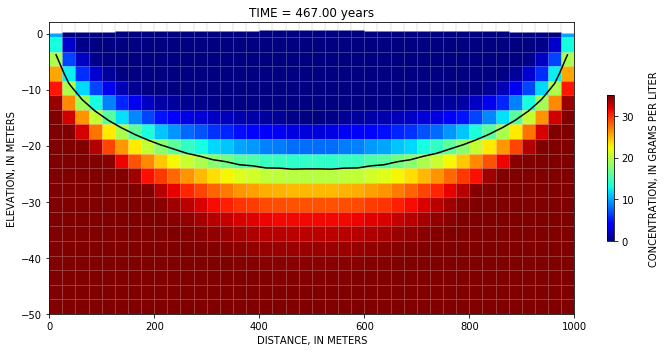

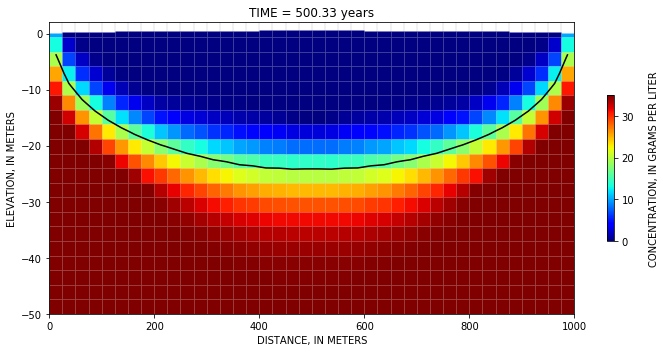

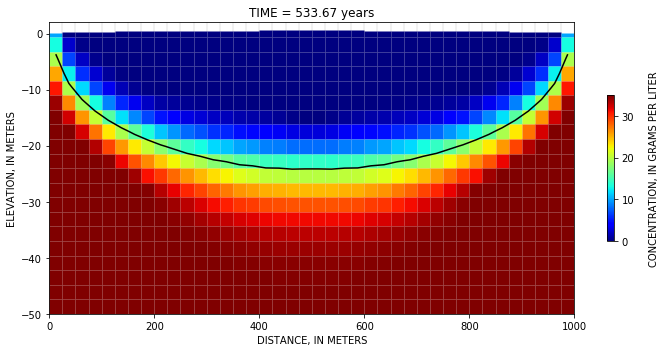

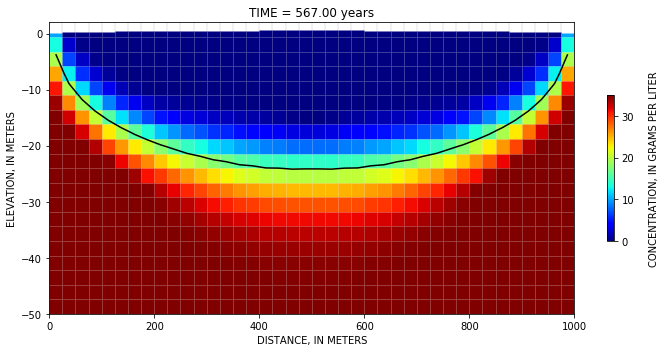

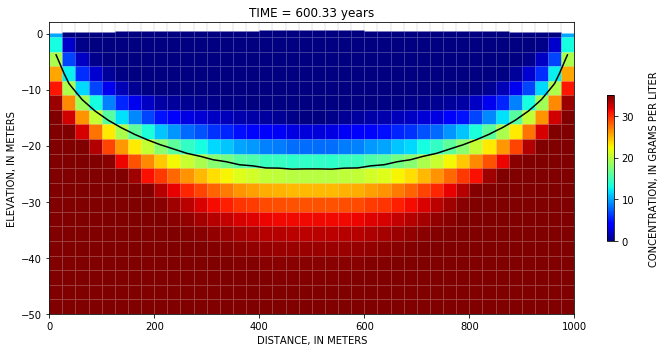

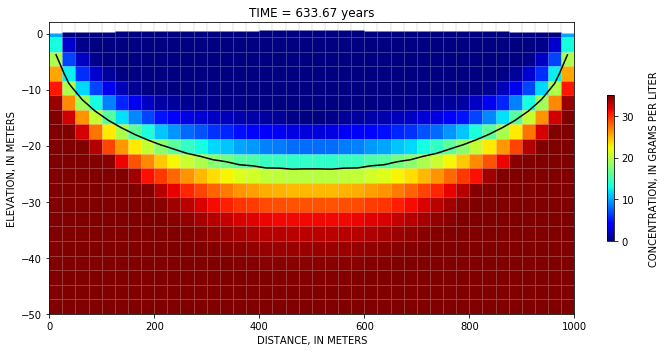

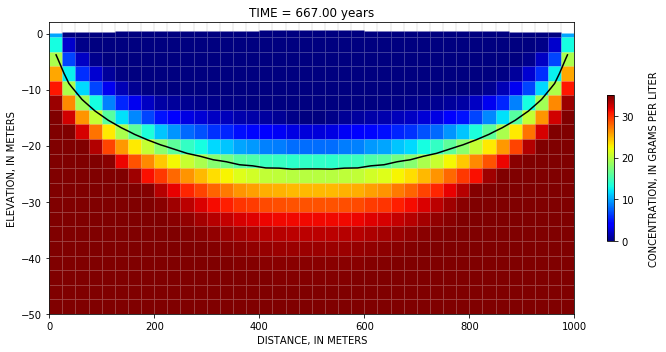

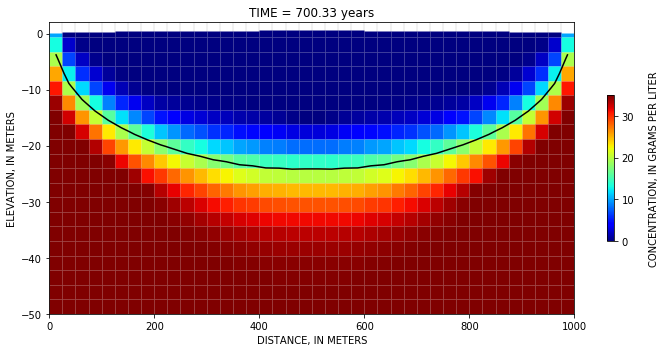

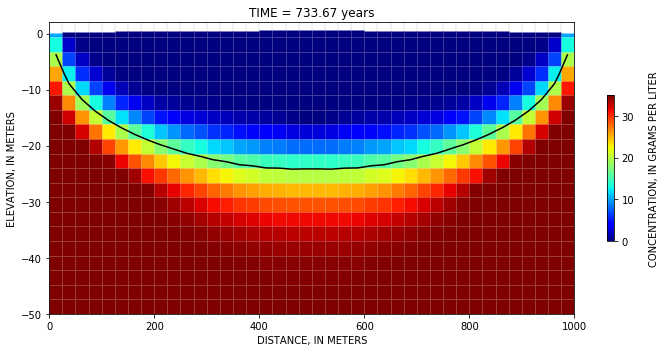

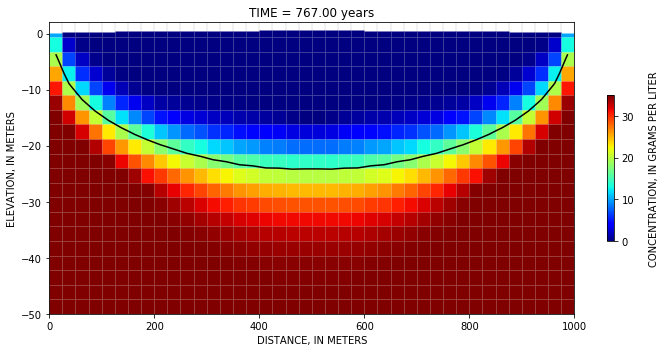

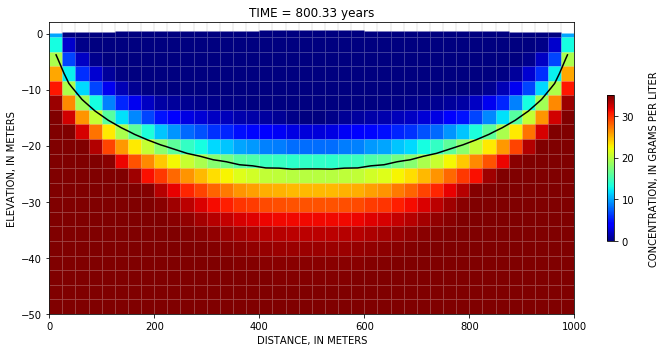

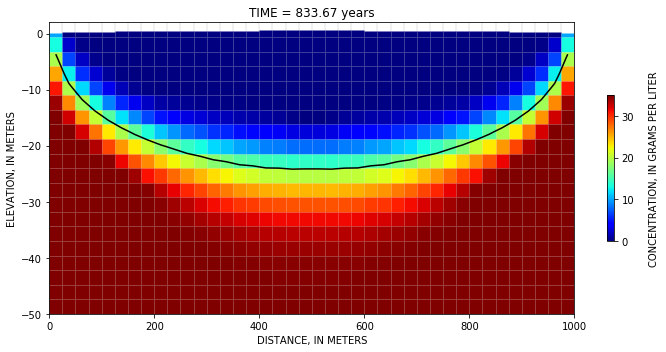

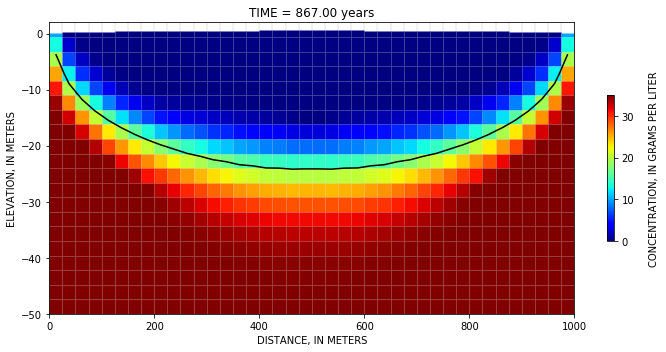

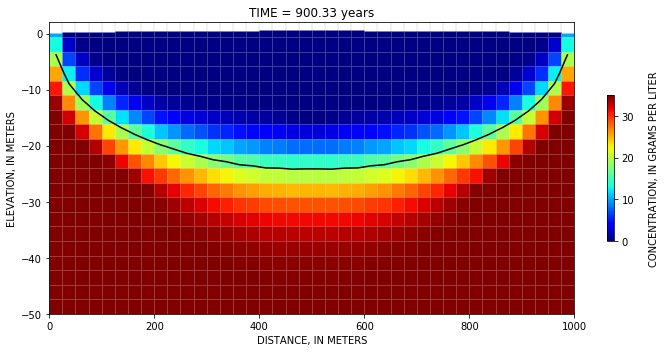

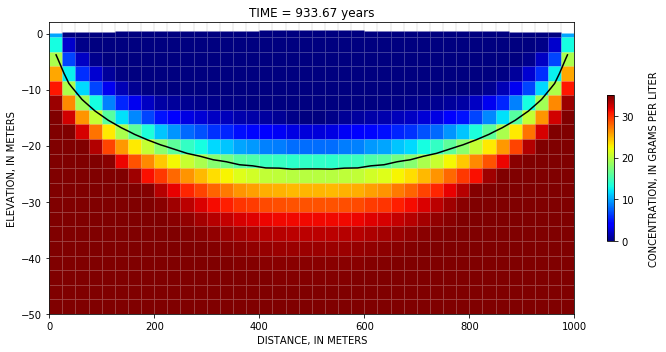

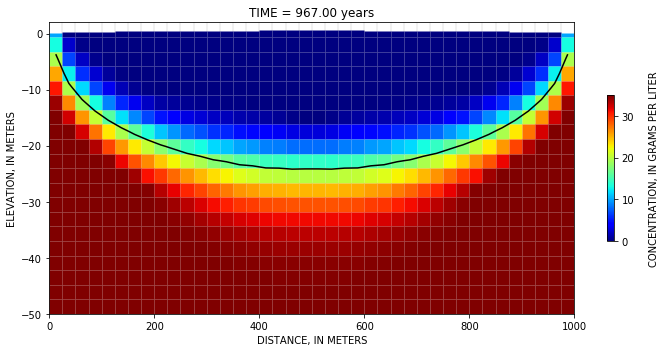

In [22]:
make_png = True
if make_png:

    pngdir = os.path.join(ws0, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc0.shape[0], 100)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        conctoplot = conc0[kper]
        headtoplot = head0[kper]
        if lakconc0 is not None:
            conctoplot = np.where(conctoplot > 1e20, lakconc0[kper, 0, 0, 0], conctoplot)
        if stage0 is not None:
            headtoplot = np.where(headtoplot > 1e20, stage0[kper, 0, 0, 0], headtoplot)
        ax = make_figure(gwf, headtoplot, conctoplot, spdis0[kper], 
                         times0[kper], top0, streamplot=False)
        
        make_figure(gwf, headtoplot, conctoplot, spdis0[kper], 
                    times0[kper], top0,
                    streamplot=False, figname=fname)
        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws0, 'movie.mp4')
    make_movie(figfile, anmfile)

In [ ]:
idomain.shape

In [ ]:
plt.plot(times0, conc0[:, int(nlay/2), 0, int(ncol/2)])

In [ ]:
plt.plot(times0, stage0[:, 0, 0, 0])

In [ ]:
plt.plot(times0, lakconc0[:, 0, 0, 0])

# Model Run with SLR

In [38]:
time_end = 100 * 365.
nper = 100 * 5
ws = 'temp/pxx_gwt_lakoffslr1'
name = 'lakslr1'
sim = get_model(ws, name, nlay, nrow, ncol, lx,
                 top0, bottom, 
                 time_end, 
                 hk, vk, specific_storage, porosity, 
                 recharge,
                 alpha_l, alpha_t,
                 cfresh, csalt,
                 hlak=0,
                 clak=0,
                 sl_start=0., slr_rate=1./(365. * 100),
                 lakeon=False,
                 nper=nper, cstrt=conc0[-1],
                 verbosity_level=1,
                 converge_continue=True)
sim.write_simulation()
v = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing ims package ims_0...
  writing package lakslr1.gwfgwt...
  writing model gwf_lakslr1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package buy...
    writing package ghb-0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 40 based on size of stress_period_data
    writing package rcha...
    writing package oc...
  writing model gwt_lakslr1...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package mst...
    writing package ssm...
    writing package oc...
FloPy is using the following  executable to run the model: /Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODU

 Solving:  Stress period:   148    Time step:     1
 Solving:  Stress period:   149    Time step:     1
 Solving:  Stress period:   150    Time step:     1
 Solving:  Stress period:   151    Time step:     1
 Solving:  Stress period:   152    Time step:     1
 Solving:  Stress period:   153    Time step:     1
 Solving:  Stress period:   154    Time step:     1
 Solving:  Stress period:   155    Time step:     1
 Solving:  Stress period:   156    Time step:     1
 Solving:  Stress period:   157    Time step:     1
 Solving:  Stress period:   158    Time step:     1
 Solving:  Stress period:   159    Time step:     1
 Solving:  Stress period:   160    Time step:     1
 Solving:  Stress period:   161    Time step:     1
 Solving:  Stress period:   162    Time step:     1
 Solving:  Stress period:   163    Time step:     1
 Solving:  Stress period:   164    Time step:     1
 Solving:  Stress period:   165    Time step:     1
 Solving:  Stress period:   166    Time step:     1
 Solving:  S

 Solving:  Stress period:   324    Time step:     1
 Solving:  Stress period:   325    Time step:     1
 Solving:  Stress period:   326    Time step:     1
 Solving:  Stress period:   327    Time step:     1
 Solving:  Stress period:   328    Time step:     1
 Solving:  Stress period:   329    Time step:     1
 Solving:  Stress period:   330    Time step:     1
 Solving:  Stress period:   331    Time step:     1
 Solving:  Stress period:   332    Time step:     1
 Solving:  Stress period:   333    Time step:     1
 Solving:  Stress period:   334    Time step:     1
 Solving:  Stress period:   335    Time step:     1
 Solving:  Stress period:   336    Time step:     1
 Solving:  Stress period:   337    Time step:     1
 Solving:  Stress period:   338    Time step:     1
 Solving:  Stress period:   339    Time step:     1
 Solving:  Stress period:   340    Time step:     1
 Solving:  Stress period:   341    Time step:     1
 Solving:  Stress period:   342    Time step:     1
 Solving:  S

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/09/24 10:51:09
 Elapsed run time:  2.388 Seconds

 Normal termination of simulation.


In [39]:
# load results
head, conc, spdis, stage, lakconc, times = get_results(ws, sim)
gwf = sim0.get_model('gwf_lakslr')

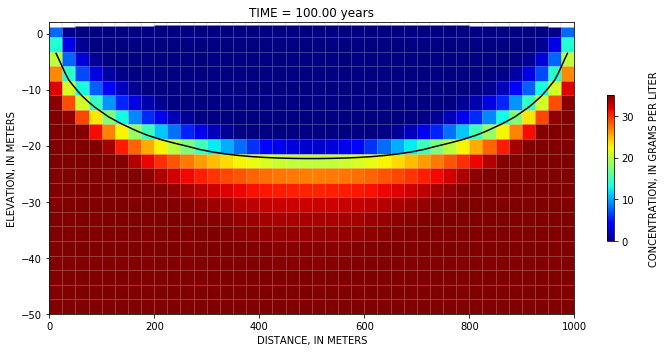

In [42]:
kper = -1
conctoplot = conc[kper]
headtoplot = head[kper]
if lakconc0 is not None:
    conctoplot = np.where(conctoplot > 1e20, lakconc[kper, 0, 0, 0], conctoplot)
if stage0 is not None:
    headtoplot = np.where(headtoplot > 1e20, stage[kper, 0, 0, 0], headtoplot)
ax = make_figure(gwf, headtoplot, conctoplot, spdis[kper], 
                 times[kper], top0, streamplot=False)

In [27]:
plt.plot(times, stage[:, 0, 0, 0])

TypeError: 'NoneType' object is not subscriptable

In [28]:
plt.plot(times, lakconc[:, 0, 0, 0])

TypeError: 'NoneType' object is not subscriptable

/Users/langevin/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


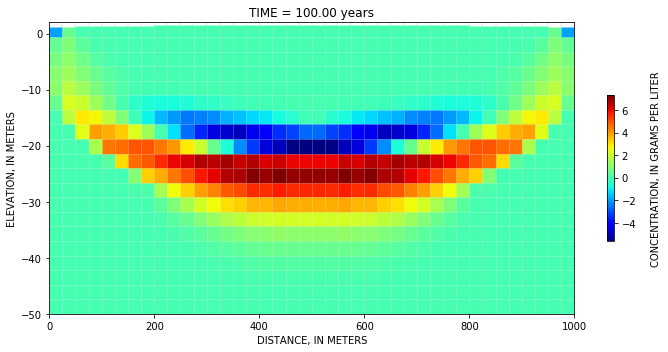

In [29]:
conctoplot = np.ma.masked_greater(conc[-1] - conc0[-1], 1e20)
ax = make_figure(gwf, head[kper], conctoplot, spdis[kper], 
                 times[kper], top0, streamplot=False)

In [33]:
make_png = True
if make_png:

    pngdir = os.path.join(ws, 'png')
    if os.path.isdir(pngdir):
        shutil.rmtree(pngdir)
    if not os.path.isdir(pngdir):
        os.mkdir(pngdir)

    kperlist = range(0, conc.shape[0], 1)
    #kperlist = [0]
    for ifig, kper in enumerate(kperlist):
        fname = 'img{}.png'.format(ifig)
        fname = os.path.join(pngdir, fname)
        print('writing {}'.format(fname))

        conctoplot = conc[kper]
        headtoplot = head[kper]
        if lakconc is not None:
            conctoplot = np.where(conctoplot > 1e20, lakconc0[kper, 0, 0, 0], conctoplot)
        if stage is not None:
            headtoplot = np.where(headtoplot > 1e20, stage0[kper, 0, 0, 0], headtoplot)
        ax = make_figure(gwf, headtoplot, conctoplot, spdis[kper], 
                         times[kper], top0, streamplot=False,
                         figname=fname)

        
    # Use ffmpeg to make an animation
    figfile = os.path.join(pngdir, 'img%d.png')
    anmfile = os.path.join(ws, 'movie.mp4')
    make_movie(figfile, anmfile)

writing temp/pxx_gwt_lakoffslr1/png/img0.png
writing temp/pxx_gwt_lakoffslr1/png/img1.png
writing temp/pxx_gwt_lakoffslr1/png/img2.png
writing temp/pxx_gwt_lakoffslr1/png/img3.png
writing temp/pxx_gwt_lakoffslr1/png/img4.png
writing temp/pxx_gwt_lakoffslr1/png/img5.png
writing temp/pxx_gwt_lakoffslr1/png/img6.png
writing temp/pxx_gwt_lakoffslr1/png/img7.png
writing temp/pxx_gwt_lakoffslr1/png/img8.png
writing temp/pxx_gwt_lakoffslr1/png/img9.png
writing temp/pxx_gwt_lakoffslr1/png/img10.png
writing temp/pxx_gwt_lakoffslr1/png/img11.png
writing temp/pxx_gwt_lakoffslr1/png/img12.png
writing temp/pxx_gwt_lakoffslr1/png/img13.png
writing temp/pxx_gwt_lakoffslr1/png/img14.png
writing temp/pxx_gwt_lakoffslr1/png/img15.png
writing temp/pxx_gwt_lakoffslr1/png/img16.png
writing temp/pxx_gwt_lakoffslr1/png/img17.png
writing temp/pxx_gwt_lakoffslr1/png/img18.png
writing temp/pxx_gwt_lakoffslr1/png/img19.png
writing temp/pxx_gwt_lakoffslr1/png/img20.png
writing temp/pxx_gwt_lakoffslr1/png/img21.pn

writing temp/pxx_gwt_lakoffslr1/png/img177.png
writing temp/pxx_gwt_lakoffslr1/png/img178.png
writing temp/pxx_gwt_lakoffslr1/png/img179.png
writing temp/pxx_gwt_lakoffslr1/png/img180.png
writing temp/pxx_gwt_lakoffslr1/png/img181.png
writing temp/pxx_gwt_lakoffslr1/png/img182.png
writing temp/pxx_gwt_lakoffslr1/png/img183.png
writing temp/pxx_gwt_lakoffslr1/png/img184.png
writing temp/pxx_gwt_lakoffslr1/png/img185.png
writing temp/pxx_gwt_lakoffslr1/png/img186.png
writing temp/pxx_gwt_lakoffslr1/png/img187.png
writing temp/pxx_gwt_lakoffslr1/png/img188.png
writing temp/pxx_gwt_lakoffslr1/png/img189.png
writing temp/pxx_gwt_lakoffslr1/png/img190.png
writing temp/pxx_gwt_lakoffslr1/png/img191.png
writing temp/pxx_gwt_lakoffslr1/png/img192.png
writing temp/pxx_gwt_lakoffslr1/png/img193.png
writing temp/pxx_gwt_lakoffslr1/png/img194.png
writing temp/pxx_gwt_lakoffslr1/png/img195.png
writing temp/pxx_gwt_lakoffslr1/png/img196.png
writing temp/pxx_gwt_lakoffslr1/png/img197.png
writing temp/

writing temp/pxx_gwt_lakoffslr1/png/img352.png
writing temp/pxx_gwt_lakoffslr1/png/img353.png
writing temp/pxx_gwt_lakoffslr1/png/img354.png
writing temp/pxx_gwt_lakoffslr1/png/img355.png
writing temp/pxx_gwt_lakoffslr1/png/img356.png
writing temp/pxx_gwt_lakoffslr1/png/img357.png
writing temp/pxx_gwt_lakoffslr1/png/img358.png
writing temp/pxx_gwt_lakoffslr1/png/img359.png
writing temp/pxx_gwt_lakoffslr1/png/img360.png
writing temp/pxx_gwt_lakoffslr1/png/img361.png
writing temp/pxx_gwt_lakoffslr1/png/img362.png
writing temp/pxx_gwt_lakoffslr1/png/img363.png
writing temp/pxx_gwt_lakoffslr1/png/img364.png
writing temp/pxx_gwt_lakoffslr1/png/img365.png
writing temp/pxx_gwt_lakoffslr1/png/img366.png
writing temp/pxx_gwt_lakoffslr1/png/img367.png
writing temp/pxx_gwt_lakoffslr1/png/img368.png
writing temp/pxx_gwt_lakoffslr1/png/img369.png
writing temp/pxx_gwt_lakoffslr1/png/img370.png
writing temp/pxx_gwt_lakoffslr1/png/img371.png
writing temp/pxx_gwt_lakoffslr1/png/img372.png
writing temp/

In [32]:
conc.shape[0]

500

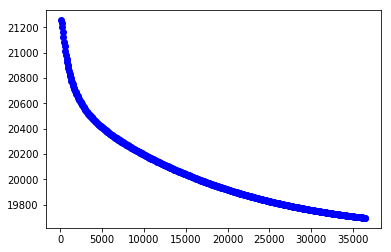

In [36]:
delr = lx / ncol
delv = (top0 - bottom) / nlay
top = gwf.dis.top.array
botm = gwf.dis.botm.array
vlenslist = []
for kper in range(conc.shape[0]):
    c = conc[kper]
    hd = head[kper]
    nlay, nrow, ncol = c.shape
    vlens = 0.
    for k in range(nlay):
        for j in range(ncol):
            f = (1. - c[k, 0, j] / csalt)                
            h = hd[k, 0, j]
            if k == 0:
                ht = top[0, j]
            else:
                ht = botm[k - 1, 0, j]
            ht = max(min(h, ht), botm[k, 0, j])
            delv = (ht - botm[k, 0, j])
            vlens += f * delr * delv 
    vlenslist.append(vlens)
plt.plot(times, vlenslist, 'bo-')

In [37]:
slp = (vlenslist[-1] - vlenslist[0]) / 100.
print(slp)

-15.597268884017176
